## Importing Libraries

In [1]:
# %pip install tensorflow keras keras-tuner opencv-python matplotlib pandas

In [2]:
import matplotlib.pyplot as plt
#import numpy as np
#import pandas as pd
import tensorflow as tf
import time
import keras_tuner as kt
import os

from keras.utils import image_dataset_from_directory, load_img
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Rescaling
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


2023-10-06 19:22:52.386812: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-06 19:22:52.439215: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-06 19:22:52.439482: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-06 19:22:52.439614: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-06 19:22:52.448841: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-06 19:22:52.449428: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Using TensorFlow backend


## EDA

In [3]:
picture_size = 48
folder_path = "../Ht23-Deep-Learning-Tentamen/images/"

In [4]:
os.listdir(folder_path+"train")

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

angry


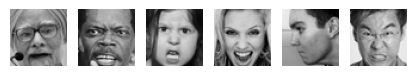

disgust


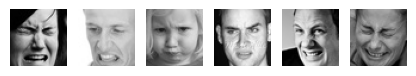

fear


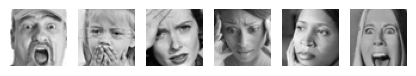

happy


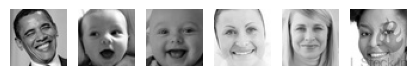

neutral


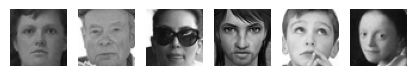

sad


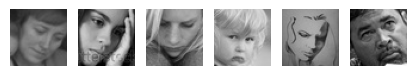

surprise


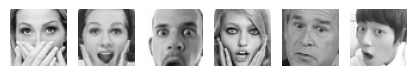

In [5]:
# List of directories containing all expressions
expression = list(os.listdir(folder_path+"train"))

# Plot subplot without labels
for exp in expression:
    plt.figure(figsize= (6,6))
    print(exp)
    for i in range(1, 7, 1):
        plt.subplot(1,7,i)
        plt.axis('off')
        img = load_img(folder_path+"train/"+exp+"/"+
                       os.listdir(folder_path + "train/" + exp)[i], target_size=(picture_size, picture_size))
        plt.imshow(img)
    plt.show()


# Making Training and Validation Data

In [6]:
batch_size  = 32

# tf.keras.utils.image_dataset_from_directory
train_ds = image_dataset_from_directory(
    folder_path+"train",
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size
    )

val_ds = image_dataset_from_directory(
    folder_path+"validation",
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    shuffle=False
    )

Found 28821 files belonging to 7 classes.
Using 23057 files for training.
Found 7066 files belonging to 7 classes.
Using 1413 files for validation.


In [7]:
# Normalization layer
normalization_layer = Rescaling(1./255)

# Normalizes the training and validation datasets
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [8]:
# Take 100 images from the normalized datasets to speed up training while testing
normalized_train_ds = normalized_train_ds.take(100)
normalized_val_ds = normalized_val_ds.take(100)

In [9]:
# Caches the datasets to memory to prevent I/O bottleneck
AUTOTUNE = tf.data.AUTOTUNE

normalized_train_ds = normalized_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalized_val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model Building

In [10]:
def build_model(hp):
    no_of_classes = 7
    input_shape = (picture_size, picture_size, 1)

    model = Sequential()

    # Tune the number of convolutional layers in the stack _with_ kernel size and stride tuning
    for i in range(2):
        model.add(Conv2D(
            # Tune the number of filters separately in each convolutional layer
            filters=hp.Int(f"units_{i}", min_value=32, max_value=156, step=32),
            # Tune the kernel size and stride separately in each convolutional layer
            kernel_size=hp.Int(f"units_{i}", min_value=3, max_value=5, step=2),
            # Tune the stride separately in each convolutional layer
            strides=hp.Int(f"units_{i}", min_value=1, max_value=2, step=1),
            padding='same',
            activation='relu',
            input_shape=input_shape
            )
        )
        model.add(BatchNormalization())
        if hp.Boolean("pooling"):
            model.add(MaxPooling2D(pool_size=2))
        if hp.Boolean("dropout"):
            model.add(Dropout(rate=0.25))

    # Tunes the number of convolutional layers in the stack _without_ kernel size and stride tuning
    for i in range(hp.Int("conv_layers", 1, 3)):
        model.add(Conv2D(
            filters=hp.Int(f"units_{i}", min_value=448, max_value=576, step=32),
            kernel_size=3,
            padding='same',
            activation='relu',
            )
        )
        model.add(BatchNormalization())
        if hp.Boolean("pooling"):
            model.add(MaxPooling2D(pool_size=2))
        if hp.Boolean("dropout"):
            model.add(Dropout(rate=0.25))

    model.add(Flatten())

    # Tune the number of dense layers in the model
    for i in range(hp.Int("dense_layers", 1, 3)):
        model.add(
            Dense(
                # Tune the number of units separately in each dense layer
                hp.Int(f"units_{i}", min_value=192, max_value=576, step=32),
                activation='relu'
            )
        )
        model.add(BatchNormalization())
        if hp.Boolean("dropout"):
            model.add(Dropout(rate=0.25))

    model.add(Dense(no_of_classes, activation='softmax'))

    # Tune the learning rate for the optimizer
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [11]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10)

tuner.search_space_summary()

Search space summary
Default search space size: 7
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 156, 'step': 32, 'sampling': 'linear'}
pooling (Boolean)
{'default': False, 'conditions': []}
dropout (Boolean)
{'default': False, 'conditions': []}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 156, 'step': 32, 'sampling': 'linear'}
conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [12]:
tuner_early_stopping = EarlyStopping(monitor='val_loss',
                                     min_delta=0,
                                     patience=5,
                                     verbose=1,
                                     restore_best_weights=True,
                                     start_from_epoch=2
                                     )

tuner.search(normalized_train_ds, epochs=30, validation_data=(normalized_val_ds), callbacks=[tuner_early_stopping])
best_model = tuner.get_best_models()[0]

Trial 2 Complete [00h 00m 00s]

Best val_accuracy So Far: None
Total elapsed time: 00h 00m 01s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
64                |96                |units_0
True              |True              |pooling
True              |True              |dropout
32                |96                |units_1
2                 |2                 |conv_layers
1                 |2                 |dense_layers
0.0007256         |0.0051684         |lr



Traceback (most recent call last):
  File "/home/chris/Documents/Coding/Ht23-Deep-Learning-Tentamen/.conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/chris/Documents/Coding/Ht23-Deep-Learning-Tentamen/.conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/chris/Documents/Coding/Ht23-Deep-Learning-Tentamen/.conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/home/chris/Documents/Coding/Ht23-Deep-Learning-Tentamen/.conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "/home/chris/Documents/Coding/Ht23-Deep-Learning

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/home/chris/Documents/Coding/Ht23-Deep-Learning-Tentamen/.conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/chris/Documents/Coding/Ht23-Deep-Learning-Tentamen/.conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/chris/Documents/Coding/Ht23-Deep-Learning-Tentamen/.conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/home/chris/Documents/Coding/Ht23-Deep-Learning-Tentamen/.conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "/home/chris/Documents/Coding/Ht23-Deep-Learning-Tentamen/.conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
  File "/home/chris/Documents/Coding/Ht23-Deep-Learning-Tentamen/.conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 155, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "/tmp/ipykernel_8727/822337719.py", line 23, in build_model
    model.add(MaxPooling2D(pool_size=2))
  File "/home/chris/Documents/Coding/Ht23-Deep-Learning-Tentamen/.conda/lib/python3.10/site-packages/tensorflow/python/trackable/base.py", line 204, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/home/chris/Documents/Coding/Ht23-Deep-Learning-Tentamen/.conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/chris/Documents/Coding/Ht23-Deep-Learning-Tentamen/.conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py", line 1021, in _create_c_op
    raise ValueError(e.message)
ValueError: Exception encountered when calling layer "max_pooling2d" (type MaxPooling2D).

Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling2d/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](Placeholder)' with input shapes: [?,1,1,64].

Call arguments received by layer "max_pooling2d" (type MaxPooling2D):
  • inputs=tf.Tensor(shape=(None, 1, 1, 64), dtype=float32)


In [ ]:
tuner.results_summary()
best_model = tuner.get_best_models()[0]

In [ ]:
self_trained_model = load_model('model_self_trained.h5')
self_test_loss, self_test_acc, _ = self_trained_model.evaluate(normalized_val_ds, verbose=2)
print('Self-trained test accuracy:', self_test_acc)

In [ ]:
self_trained_model = load_model('model_self_trained_v0.2.h5')
self_test_loss, self_test_acc, _ = self_trained_model.evaluate(normalized_val_ds, verbose=2)
print('Self-trained test accuracy:', self_test_acc)

In [ ]:
self_trained_model = load_model('model_self_trained_v0.3.h5')
self_test_loss, self_test_acc = self_trained_model.evaluate(normalized_val_ds, verbose=2)
print('Self-trained test accuracy:', self_test_acc)

In [ ]:
self_trained_model = load_model('model_self_trained.h5')
self_trained_model.summary()

In [ ]:
pre_trained_model = load_model('model_pre_trained.h5')
pre_test_loss, pre_test_acc = pre_trained_model.evaluate(normalized_val_ds, verbose=2)
print('Pre-trained test accuracy:', pre_test_acc)

# Fitting the Model with Training and Validation Data 

In [ ]:
checkpoint = ModelCheckpoint("./model_self_trained_test.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=5,
                               verbose=1,
                               restore_best_weights=True
                               )

# Does this do anything?
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.2,
                                        patience=3,
                                        verbose=1,
                                        min_delta=0.0001
                                        )

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 100

best_model.compile(loss='CategoricalCrossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy']
              )

In [ ]:
# steps_per_epoch and validation_steps commented out due to default values

history = best_model.fit(normalized_train_ds,
                    # steps_per_epoch=train_ds.n//train_ds.batch_size,
                    epochs=epochs,
                    validation_data = normalized_val_ds,
                    # validation_steps = val_ds.n//val_ds.batch_size,
                    callbacks=callbacks_list
                    )

# Plotting Accuracy & Loss

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()